# Introduction
Given a rectangular grid of random numbers representing the time cost of each cell, we are required to find the fastest path from top left corner to the destination at the bottom right. One can only move right, left, top or down by one cell each step.


In [1]:
import random
import numpy as np
from math import comb
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats.distributions
import itertools

After import, let's set random seed and random functions first. We will use random functions to investiagte impact of distribution later. Some random functions don't need two arguments, but we still give 2 arguments for consistency to enable use by other functions.

In [2]:
#set fixed random seed 
np.random.seed(1)
rng = np.random.default_rng()

#set random functions
def uniform_integer (mean=4.5, variance=8.25):
    return np.random.randint(0, mean*2+1)

def uniform_continuous(mean=4.5, variance=6.75):
    return np.random.random()*mean*2

def poisson (mean=4.5, variance=4.5):
    return rng.poisson(mean)

def negative_binomial (k=3, p=2/3): #default has mean=4.5
    return rng.negative_binomial(k, p)

def gamma (alpha, scale):
    return rng.gamma(alpha, scale)

def lognormal (mean, sigma):
    return rng.lognormal(mean, sigma)

# Algorithm for finding path

For convenience, first build functions that adopt certain algorithm for finding the best path, which can be used as default function for playing the game. The function would take grid in 2D array data format as input argument.

Let's have L-shape path for illustration.

In [3]:
def Lshape_path(grid_2Darray):
    L_path = np.zeros_like(grid_2Darray)
    L_path[1:, 0] = 1
    L_path[-1, 1:-1] = 1
    time = np.sum(grid_2Darray * L_path)
    return L_path, time

# Naïve approach
Then let's build a naive path function. 
Imagine a grid to turn 45 degrees with starting point at the top. Its first half looks like a tree diagram and its second half an inverted one. For each step one just needs to go down left or right – equivalent to right and down in the original grid. This is also like a Pascal triangle, which can be used to calculate the no. of combinations of right and down for passing each cell.
First trial: we first assume the best path only needs to go either right or down in each step. All combinations of right and down are calculated to get the minimum path, with total no. of steps = (no. of rows -1) + (no. of columns -1). 
   

In [4]:
def naive_path(grid_2Darray):

    rows, columns = np.shape(grid_2Darray)
    
    if rows == 1 or columns == 1:   #check for trivial case
        n_path = np.ones_like(grid_2Darray)
        n_path[0,0] = 0
        n_path[-1,-1] = 0
        best_time = np.sum(grid_2Darray * n_path)
    else:
    
        n_path = np.zeros_like(grid_2Darray)

        right = [0,1]
        down = [1,0]
        steps = rows+columns-2
        path_all_right = np.tile(right, (steps, 1))
        #initialize with maximum value
        best_time = np.max(grid_2Darray)*(rows+columns-2)
    
        #loop for combinations from moves of (rows-1) down and (columns-1) right
        for i in itertools.combinations(range(steps), rows-1):
            path_steps = path_all_right.copy()
            position = [0,0]
            path_map = np.zeros((rows, columns))
        
            for x in i: #generate each path steps
                path_steps[x] = down
            
            for j in range(steps-1): #exclude destination step, generate path map data
                position = position + path_steps[j]
                n, m = position
                path_map[n, m] = 1 
            
            time = np.sum(grid_2Darray * path_map) 
            if time <= best_time:
                n_path = path_map.copy() 
                best_time = time
        
    return n_path, best_time

Let's try some improvement as the above takes too long computation time.

Naïve_split_path below is created by splitting the grid into two triangles along a diagonal, 
as the path must pass through at least one cell of the diagonal, 
which is each treated as end-point of first part and start-point of the second part.  
Run the naïve algorithm for each diagonal cell twice for each part 
(which is much smaller than the whole triangle) and sum up the result, 
then we can choose the diagonal cell through which the combined path is the shortest. 
For non-square grid, shorter side is used to choose “diagonal” cells. 


In [5]:
def naive_split_path(grid_2Darray):
    rows, columns = np.shape(grid_2Darray)
    
    if comb(rows+columns-2, rows-1) < 1000:
        n_path, best_time = naive_path(grid_2Darray)
    else:
        best_time = np.max(grid_2Darray)*(rows+columns-2)  #initiate with a large num
        n_path = np.zeros((rows, columns))
        #split by checking diagonal points
        for i in range(min(rows,columns)):
            j = columns-1-i
            n_path1, best_time1 = naive_path(grid_2Darray[0:(i+1), 0:(j+1)])
            n_path2, best_time2 = naive_path(grid_2Darray[i:rows, j:columns])
            best_time_temp = best_time1 + best_time2 + grid_2Darray[i,j]
            if best_time_temp < best_time:
                best_time = best_time_temp
                n_path1 = np.concatenate((n_path1, np.zeros((rows-1-i,j+1))),axis=0)
                n_path1 = np.concatenate((n_path1, np.zeros((rows,columns-j-1)) ),axis=1)
                n_path2 = np.concatenate((np.zeros((i,columns-j)), n_path2),axis=0 )
                n_path2 = np.concatenate((np.zeros((rows,j)), n_path2),axis=1)
                n_path = n_path1 + n_path2
                n_path[i,j] = 1
                
    return n_path, best_time

# Dijkstra Algorithm
The same classes “grid” and “path” are used as those in naïve approach, but Dijkstra function is built as input function to calculate the path. This algorithm focuses on all and only adjacent nodes to calculate distance (time in our case) for each step, and then ignore those already calculated and visited. It calculates and stores the distance travelled to the current node and check if neighbour nodes can be reached from current node with shorter distance/time. It moves forward each step to an adjacent node that is the nearest and update which preceding node leading to shortest distance, until it finally reaches the destination.

In [6]:
def Dijkstra(grid_2Darray):
    rows, columns = np.shape(grid_2Darray)
    if rows == 1 or columns == 1: #solve for trivial case
        n_path = np.ones_like(grid_2Darray)
        n_path[0,0] = 0
        n_path[-1,-1] = 0
        best_time = np.sum(grid_2Darray * n_path)
    else:
        #initialization
        n_path = np.zeros_like(grid_2Darray)
        Max = np.amax(grid_2Darray)*rows*columns #for later initializiation with infinity
        visit = np.zeros_like(grid_2Darray) #1 for visited, 0 for unvisited
        distance = np.full((rows, columns),Max) #initialize each node as very large distance (aka infinity in original version) for comparing in later stage
        distance[0,0]=0 # first current node
        preceding_node_set = np.empty((rows, columns), dtype=object)
        current_node = np.array([0,0],dtype=int)
        U = [-1,0]
        D = [1, 0]
        L = [0,-1]
        R = [0,1]
        actions = [U, D, L, R]
       
        #loop until destination is visited
        while visit[-1,-1] == 0 :
            for action in actions:
                i,j = current_node + action #look for neighbour [i,j]
                if i in range(0,rows) and j in range(0,columns) and visit[i,j] == 0:
                    distance_temp = distance[current_node[0], current_node[1]] + grid_2Darray[i,j]
                    if distance_temp < distance[i,j]:
                        distance[i,j] = distance_temp
                        preceding_node_set[i,j] = current_node
            visit[current_node[0],current_node[1]] = 1 #update list of visited nodes so that current node won't be visited again
            distance[current_node[0],current_node[1]] = float('inf')  #equivalent to removing it for checking shortest distance node that is not yet visited
            current_node = np.asarray(divmod(np.nanargmin(distance),columns)) #get node of shortest distance
        
        #get path
        i,j = preceding_node_set[-1,-1]
        while not(i==0) or not(j==0) :
            n_path[i,j] += 1
            i,j = preceding_node_set[i,j]
        
        best_time = np.sum(grid_2Darray * n_path)
    return n_path, best_time

# Coding architecture of the game
Using Python, a class “grid” is built to initialize, populate and display each cell of the grid with random numbers. A sub-class for populating numbers with different probability distribution might be built as they won’t share the same numbers, but alternatively I built a class that accepts “random_function” as input, allowing different probability distributions. 


In [7]:
#set the rectangular grid
class grid:
    
    def __init__ (self, rows, columns):
        self.rows = rows
        self.columns = columns
        self.data = np.zeros((rows, columns))
        self.df = pd.DataFrame(self.data)
        
    def populate (self, arg1=4.5, arg2=8.25, random_function=uniform_integer):
        with np.nditer(self.data, op_flags=['readwrite']) as it:
            for x in it:
                x[...] = random_function(arg1, arg2)
        self.df = pd.DataFrame(self.data)
        
   # def populate_manual(self, 2Darray):
    #    self.data = 2Darray
      #  self.df = pd.DataFrame(self.data)
        
    def display (self):
        print("The grid of the game is as follows. Pls find the fastest path from top left corner to bottom right corner.")
        display(self.df)

A class “path” is built to initialize, populate and display the fastest path using certain algorithm. A sub-class for populating the path might be built as different algorithm might create different results, but alternatively I built a class that accepts “path_function” as input to allow different algorithms to be used. Using functions as input is more convenient and it avoids creating sub-classes.

In [8]:
class path():
    def __init__ (self, grid_2Darray):
        self.grid = grid_2Darray
        self.rows, self.columns = np.shape(self.grid)
     
        
    def populate(self, path_function = Dijkstra):
        self.data, self.time = path_function(self.grid)
        self.df = pd.DataFrame(self.data)
        self.algorithm = path_function.__name__
        
    
    def display (self, style = 3):
        print("")
        print("Using "+self.algorithm+" algorithm, the time cost is "+str(self.time))
        
        if style == 1 or style =="all":
            print("The path is in green as follows:")
            for i in range(self.rows):
                for j in range(self.columns):
                    if self.data[i,j] == 0:
                        print(str(self.grid[i, j]).rjust(6), end = " ")
                    else:
                        print(("\033[1;32;40m" + str(self.grid[i, j]).rjust(6) + "\033[0m"), end = " ")
                print()
        
        if style == 2 or style =="all":
            print("The fastest path excluding end-points shown in simple map:")
            plt.imshow(self.data, cmap="hot", interpolation='nearest')
            plt.show()
        
        
        if style == 3 or style == "all":
            #reference: Matplotlib website on creating annotated heatmap
            fig, ax = plt.subplots()
            im = ax.imshow(self.data)
            ax.set_xticks(np.arange(self.columns))
            ax.set_yticks(np.arange(self.rows))
            ax.set_xticklabels(np.arange(self.columns))
            ax.set_yticklabels(np.arange(self.rows))
            for i in range(self.rows):
                for j in range(self.columns):
                    text = ax.text(j, i, self.grid[i, j], ha="center", va="center", color="g")
            ax.set_title("The fastest path excluding end-points")
            fig.tight_layout()
            plt.show()

# Helper functions for investigating different factors

First, build a simulation function that can return path based on grid shape and distribution of each cell, with Dijkstra used as default path-finding function.

In [9]:
def simulation(rows=10, columns=10, arg1=4.5, arg2=8.25, random_function = uniform_integer , path_function = Dijkstra, sample=1000):
        game_test=grid(rows, columns)
        path_list = []
        for i in range(sample):
            game_test.populate(arg1, arg2, random_function)
            path_test = path(game_test.data)
            path_test.populate(path_function)
            path_list.append(path_test.time)
        
        path_values = np.array(path_list)
        path_mean = np.sum(path_values)/sample
        sample_variance = np.var(path_values) * sample/(sample-1)
            
        return path_mean, sample_variance, path_values

Then build a function to investigate impact of grid size by varying the length of grid.

For simplicity, we use square grid, using the uniform integer distribution (from 0 to 20 inclusive) with default mean 10. The length (no. of cells for each side) is varied and for each length the simulation is run 1000 times.

In [10]:
#vary the length of grid, holding mean of each cell constant
def size_factor(start=4, end=30, mean=10, sample=1000): 
    mean_list = []
    variance_list = []
    for i in range(start, end+1):
        path_mean, sample_variance, path_values = simulation(i,i,mean,sample=sample)
        mean_list.append(path_mean)
        variance_list.append(sample_variance)
    
    standard_deviation = [j**0.5 for j in variance_list]
    x = np.arange(start, end+1, 1)
    
    plt.plot(x, mean_list, label="Path mean")
    plt.plot(x, standard_deviation, label="Path standard deviation", linestyle='dotted')
    plt.plot(x, variance_list, label="Path sample variance")
    plt.title("How the size of grid affects the shortest path")
    plt.xlabel("Length of square grid")
    plt.legend()
    plt.show()

Build function to examine the impact of grid shape.

Simulation is done with the same setting except that the shape impact is studied by varying both length and width, but holding area unchanged at 144 cells.

In [11]:
#hold grid size unchanged at 144 cells, use uniform integer distribution of mean 10 for simulation
def shape_factor(): 
    rows = [1,2,3,4,6,12,24,36,48,72,144]
    columns = [int(rows[-1]/i) for i in rows] 
    mean_list = []
    variance_list = []
    for i in range(len(rows) ):
        path_mean, sample_variance, path_values = simulation(rows[i],columns[i],10)
        mean_list.append(path_mean)
        variance_list.append(sample_variance)
    
    standard_deviation = [j**0.5 for j in variance_list]
    plt.plot(rows, mean_list, label="Path mean")
    plt.plot(rows, standard_deviation, label="Path standard deviation", linestyle='dotted')
    plt.plot(rows, variance_list, label="Path sample variance")
    plt.title("How the shape of grid affects the shortest path")
    plt.xlabel("Length of rectangular grid of same area 144 cells")
    plt.legend()
    plt.show()

Build function to examine the impact of uniform discrete vs continuous distribution.

In [12]:
#vary mean of distribution, holding size of grid constant
def discrete_continuous(start_mean=4, end_mean=20, length=10): 
    mean_list1 = []
    variance_list1 = []
    mean_list2 = []
    variance_list2 = []
    for i in range(start_mean, end_mean+1):
        path_mean1, sample_variance1, path_values1 = simulation(length,length,i)
        mean_list1.append(path_mean1)
        variance_list1.append(sample_variance1)
        path_mean2, sample_variance2, path_values2 = simulation(length,length,i, random_function=uniform_continuous)
        mean_list2.append(path_mean2)
        variance_list2.append(sample_variance2)
    
    x = np.arange(start_mean, end_mean+1, 1)
    
    figure, axis = plt.subplots(1, 2)
    axis[0].plot(x, mean_list1, label = "uniform discrete")
    axis[0].plot(x, mean_list2, label = "uniform continuous")
    axis[0].set_title("Path mean")
    axis[1].plot(x, variance_list1, label = "uniform discrete")
    axis[1].plot(x, variance_list2, label = "uniform continuous")
    axis[1].set_title("Path variance")
    plt.xlabel("Mean of each cell")
    plt.suptitle("Path varying with mean of uniform discrete and continuous distribution")
    plt.legend()
    plt.show() 

Build function to examine the impact of various distribution. 

Distributions are studied by the created function “distribution_factor”, simulating 1000 times for 10x10 grid as default unless otherwise stated.

In [13]:
def distribution_factor(start, end, step=1, arg1=float('inf'), arg2=float('inf'),  length=10, distribution=poisson, xlabel=""): #vary parameter of distribution, holding size of grid constant
    mean_list1 = []
    variance_list1 = []
    x = np.arange(start, end, step)
    #check and assign which argument to loop and which remains constant
    if arg1==float('inf'):
        arg1_array = x
        arg2_array = np.array([arg2])
    else:
        arg2_array = x
        arg1_array = np.array([arg1])
    
    #loop to get different values of mean and variance using simulation function
    for i in arg1_array:
        for j in arg2_array:
            path_mean1, sample_variance1, path_values1 = simulation(length,length, i, j, random_function=distribution)
            mean_list1.append(path_mean1)
            variance_list1.append(sample_variance1)
    
    #plot the charts for path mean and variance
    figure, axis = plt.subplots(2, 1)
    axis[0].plot(x, mean_list1, label="Path mean")
    axis[0].legend(loc="upper left")
    axis[1].plot(x, variance_list1, label="Path variance")
    axis[1].legend(loc="upper left")
    plt.xlabel(xlabel)
    plt.suptitle("Path varying with "+distribution.__name__+" distribution "+ xlabel)
    plt.tight_layout()
    plt.show() 

# Run the game
Now let's start the game.

In [14]:
game1 = grid(10, 10)
game1.populate(10)
game1.display()
game1_path = path(game1.data)

The grid of the game is as follows. Pls find the fastest path from top left corner to bottom right corner.


,0,1,2,3,4,5,6,7,8,9
0,5.0,11.0,12.0,8.0,9.0,11.0,5.0,15.0,0.0,16.0
1,1.0,12.0,7.0,13.0,6.0,18.0,20.0,5.0,18.0,20.0
2,11.0,10.0,14.0,18.0,4.0,9.0,17.0,0.0,13.0,9.0
3,9.0,7.0,1.0,0.0,17.0,8.0,13.0,19.0,15.0,10.0
4,8.0,7.0,3.0,6.0,17.0,3.0,4.0,17.0,11.0,12.0
5,20.0,16.0,13.0,19.0,9.0,18.0,15.0,0.0,4.0,15.0
6,2.0,7.0,8.0,9.0,3.0,7.0,4.0,5.0,19.0,6.0
7,8.0,0.0,2.0,10.0,15.0,15.0,7.0,19.0,10.0,14.0
8,0.0,1.0,17.0,13.0,3.0,0.0,13.0,6.0,20.0,6.0
9,2.0,12.0,11.0,7.0,13.0,8.0,11.0,12.0,11.0,20.0


First, use naive_split_path to solve the problem.


Using naive_split_path algorithm, the time cost is 119.0


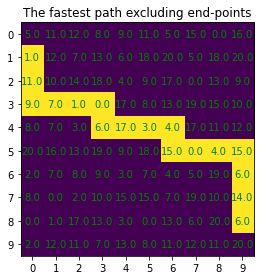

Computation time by naive_split_path: 0.03287196159362793


In [15]:
start_time2=time.time()
game1_path.populate(naive_split_path)
time2=time.time()-start_time2
game1_path.display()
print("Computation time by naive_split_path: "+str(time2))

Then we use Dijkstra algorithm to find the best path.


Using Dijkstra algorithm, the time cost is 119.0


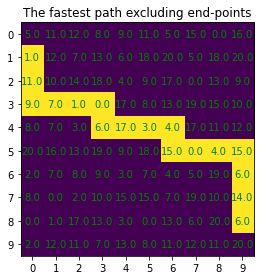

Computation time by Dijkstra: 0.0060901641845703125


In [16]:
start_time3=time.time()
game1_path.populate(Dijkstra)
time3=time.time()-start_time3
game1_path.display(style=3)
print("Computation time by Dijkstra: "+str(time3))

# Factors affecting path time

Finally, let's explore different factors affecting the path time.

### Investigate the impact of grid size.

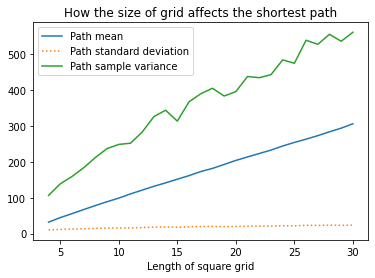

In [17]:
size_factor(4,30, mean=10)

The path mean increases almost linearly with the length of the grid, while the path variance increases more than linearly (looks like quadratically) and with more noises.

### Investigate impact of shape to the path length.

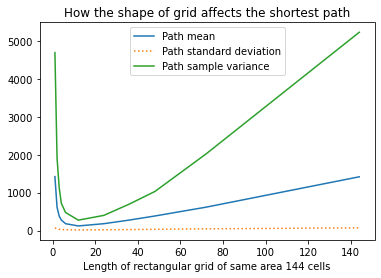

In [18]:
shape_factor()

The path mean and variance are minimum at the square shape of 12x12 grid, and increases when the shape becomes flatter – in extreme case, when it becomes 1 x 144 grid, no of cells involved is more and the path has only one choice and it cannot benefit from choosing smaller random numbers.

### Investigate uniform discrete and continuous distribution.

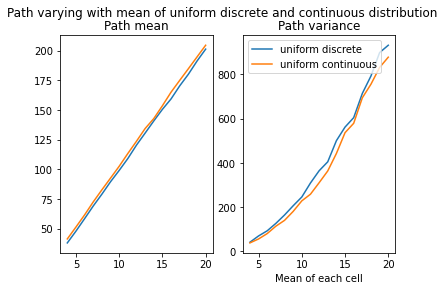

In [19]:
discrete_continuous(4,20, length=10)

The path mean is proportional to both means of uniform discrete and continuous distribution, with the discrete distribution giving slightly smaller path mean, which can be explained by its slightly higher variance giving more chance to choose smaller random number in the path. The path variance seems to increase quadratically with the means of both uniform distributions, with the discrete one giving slightly larger path variance.

### Investigate poisson distribution.

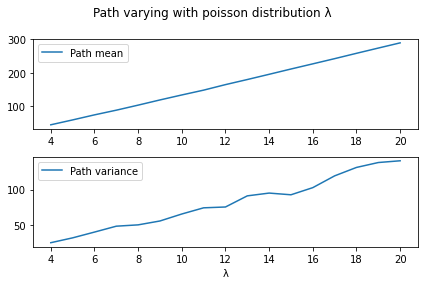

In [20]:
distribution_factor(4, 21, distribution=poisson, xlabel="λ" )

The path mean and variance both look linear and roughly proportional to λ which is the mean and variance of Poisson distribution.

### Investigate negative binomial distribution.

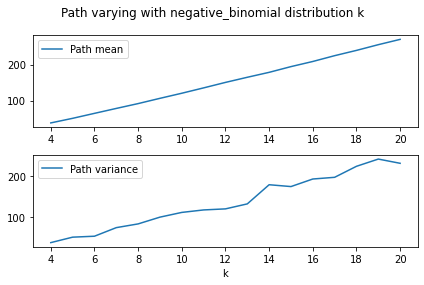

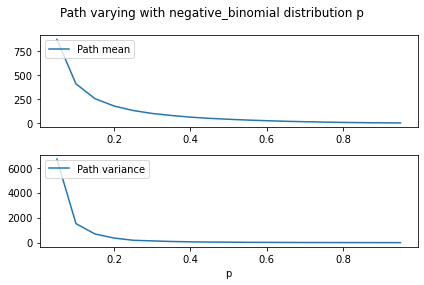

In [21]:
#k varies, holding the same p=0.5
distribution_factor(4, 21, arg2=0.5, distribution=negative_binomial, xlabel="k" ) 
#p varies, holding the same k=4
distribution_factor(0.05, 1, step=0.05, arg1=4, distribution=negative_binomial, xlabel="p" ) 

Both the path mean and variance increase linearly and almost proportionally with k, but decrease exponentially with p.

### Investigate gamma distribution.

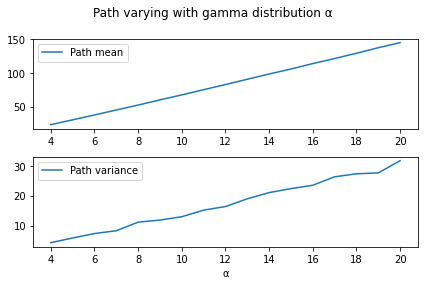

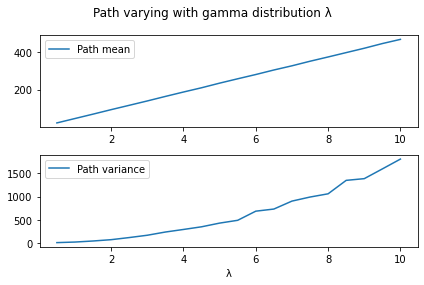

In [22]:
#α varies, holding the same λ=0.5 (and this becomes Chi-square distribution)
distribution_factor(4, 21, arg2=0.5, distribution=gamma, xlabel="α" ) 
#λ varies, holding the same α=4
distribution_factor(0.5, 10.5, step=0.5, arg1=4, distribution=gamma, xlabel="λ" )

Both the path mean and variance increase linearly and almost proportionally with α. The path mean increases linearly and almost proportionally with λ while the path variance increases exponentially with λ.

### Investigate lognormal distribution.

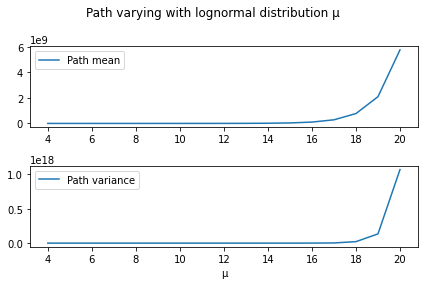

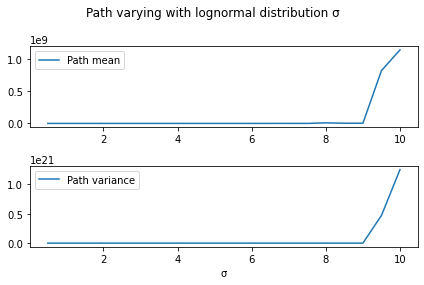

In [23]:
#μ varies, holding the same σ=1
distribution_factor(4, 21, arg2=1, distribution=lognormal, xlabel="μ" )
#λ varies, holding the same μ=4
distribution_factor(0.5, 10.5, step=0.5, arg1=4, distribution=lognormal, xlabel="σ" )

Both the path mean and variance increases exponentially with μ, σ.

# General characteristics of the path mean and variance
The path mean looks proportional to the mean of each cell, increases almost linearly with the length of the grid, and increases when the shape of grid becomes flatter (less square).
The path variance is roughly proportional to the variance of each cell with some noises, increases with length of the grid and when the shape of grid becomes flatter. For equal mean, the distribution with larger variance produces shorter path but bigger path variance.

### Reference

Wikipedia editors, 2002-2021, Wikipedia, Accessed Nov 2021, <https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm>

Barngrader, 2013, Youtube, accessed Nov 2021, <https://www.youtube.com/watch?v=0nVYi3o161A>

Hunter J., Dale D., Firing E., Droettboom M. and the Matplotlib development team, ©2002 – 2012, Matplotlib, accessed Nov 2021, <https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html>
